# Compare time-to-convergence vs. batch size
Compare the walltime to get to get from 0.0 train accuracy to 0.60 train accuracy, varying the batch size (8 nodes).

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from textwrap import wrap
import seaborn as sns
import DataSet
from collections import defaultdict
import re

In [6]:
# Load the data
files = ['../profiling_results/real/8_nodes_batchsize_32/j_759016/',
         '../profiling_results/real/8_nodes_batchsize_128/j_759017/']

d = DataSet.DataSet()
for f in files:
    d.parseInput(f, mode='batch')

## Plotting preferences

In [7]:
golden = 1.61803398875
figWidth = 5. # inches
figLength = figWidth/golden
figSize1x1 = (figWidth, figLength)

rcParams['font.sans-serif'] = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
rcParams['axes.labelsize'] = '12'
rcParams['xtick.labelsize'] = '12'
rcParams['ytick.labelsize'] = '12'
rcParams['legend.labelspacing'] = '0.1'
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True
rcParams['xtick.top'] = True
rcParams['axes.linewidth'] = 2.0
rcParams['xtick.major.size'] = 3.5
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 2.5
rcParams['xtick.minor.width'] = 1.0
rcParams['ytick.major.size'] = 3.5
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 2.5
rcParams['ytick.minor.width'] = 1.0
rcParams['lines.markersize'] = 7
rcParams['lines.linewidth'] = 1.5

markers1 = np.array(['o', '^', 's', 'x', 'd', 'v'])
markers2 = np.array(['s', 'o', 'x', '*'])
# Other options: Dark2, Pastel1, Pastel2, Accent,
# Set1, Set2, Set3, tab10, tab20, tab20b, tab20c
colors = sns.color_palette('muted') + sns.color_palette('dark',)

In [4]:
batch_size = np.array(['32', '128'])
duration_seconds = []

starts = np.array(['18:28:03.263724', '17:01:13.566772']) # 0.0 train_accuracy
stops  = np.array(['19:46:16.130530', '17:39:53.846414']) # >= 0.60 train_accuracy

fmt = '%H:%M:%S.%f'
for i,b in enumerate(batch_size):
    start = datetime.datetime.strptime(starts[i], fmt)
    stop = datetime.datetime.strptime(stops[i], fmt)
    t = stop - start
    t_seconds = t.total_seconds()
    t_minutes = int(round(t.total_seconds() / 60))
    duration_seconds.append(t_seconds)
    print("batch size = {}, duration = {} sec = {} min".format(b, t_seconds, t_minutes))

batch size = 32, duration = 4692.866806 sec = 78 min
batch size = 128, duration = 2320.279642 sec = 39 min


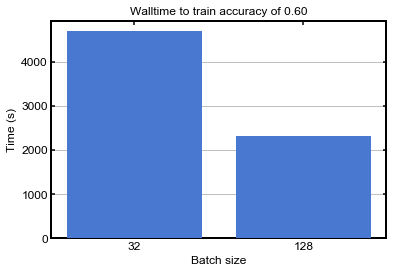

In [5]:
x = range(len(batch_size))
plt.bar(x, duration_seconds, zorder=5, color=colors[0])
plt.xlabel('Batch size')
plt.ylabel('Time (s)')
plt.title('Walltime to train accuracy of 0.60')
plt.gca().yaxis.grid(True)
plt.xticks(x, labels=batch_size);

## GPU Kernel Time

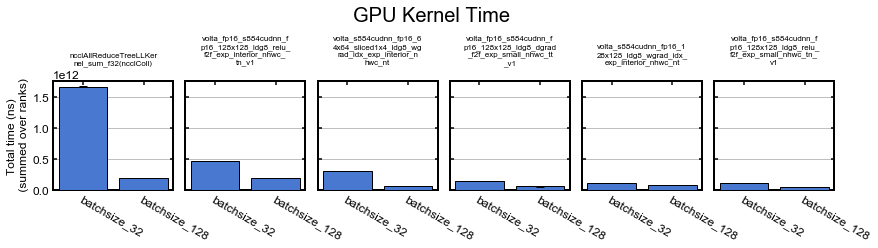

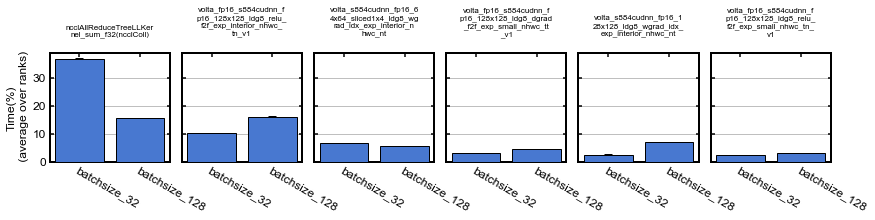

In [6]:
nRoutines = 6
all_batch = list(d._hash.keys())[:]
ranksPerNodeSummit = 6
nRanks = np.array([ranksPerNodeSummit*8 for x in all_batch])
expensiveRoutines = d['batchsize_32']['r0']['gpukernsum']['Name'][:nRoutines].values

# Compare raw times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
plt.suptitle('GPU Kernel Time', y=1.4, fontsize=20)
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[batch][r]['gpukernsum'].loc[d[batch][r]['gpukernsum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).sum() for batch in all_batch]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[batch][r]['gpukernsum'].loc[d[batch][r]['gpukernsum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).min() for batch in all_batch] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[batch][r]['gpukernsum'].loc[d[batch][r]['gpukernsum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).max() for batch in all_batch]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - nRanks*np.array(expensiveRoutineTimesMin), 
                                         nRanks*np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='8')
    plt.gca().title.set_y(1.1)
    plt.bar(all_batch, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Total time (ns)\n (summed over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/Batch_GPU_Kernel_Time_ns.png', dpi=150, bbox_inches='tight')

# Compare % times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[batch][r]['gpukernsum'].loc[d[batch][r]['gpukernsum']['Name'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).mean() for batch in all_batch]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[batch][r]['gpukernsum'].loc[d[batch][r]['gpukernsum']['Name'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).min() for batch in all_batch] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[batch][r]['gpukernsum'].loc[d[batch][r]['gpukernsum']['Name'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).max() for batch in all_batch]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - np.array(expensiveRoutineTimesMin), 
                                         np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='8')
    plt.gca().title.set_y(1.1)
    plt.bar(all_batch, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=10, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Time(%)\n (average over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/Batch_GPU_Kernel_Time_Percent.png', dpi=150, bbox_inches='tight')

## GPU Mem Time

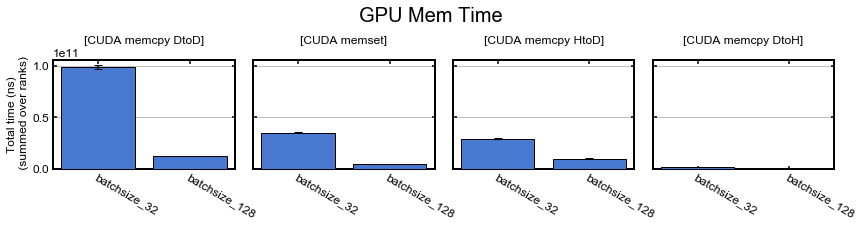

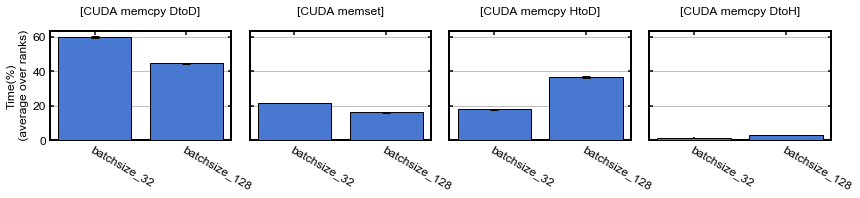

In [7]:
all_batch = list(d._hash.keys())
ranksPerNodeSummit = 6
nRanks = np.array([ranksPerNodeSummit*8 for x in all_batch])
expensiveRoutines = d['batchsize_32']['r0']['gpumemtimesum']['Operation'].values

# Compare raw times
fig, axs = plt.subplots(nrows=1, ncols=len(expensiveRoutines), sharey=True, figsize=(14, 2.))
plt.suptitle('GPU Mem Time', y=1.25, fontsize=20)
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[batch][r]['gpumemtimesum'].loc[d[batch][r]['gpumemtimesum']['Operation'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).sum() for batch in all_batch]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[batch][r]['gpumemtimesum'].loc[d[batch][r]['gpumemtimesum']['Operation'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).min() for batch in all_batch] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[batch][r]['gpumemtimesum'].loc[d[batch][r]['gpumemtimesum']['Operation'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).max() for batch in all_batch]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - nRanks*np.array(expensiveRoutineTimesMin), 
                                         nRanks*np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)))
    plt.gca().title.set_y(1.1)
    plt.bar(all_batch, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Total time (ns)\n (summed over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/Batch_GPU_Mem_Time_ns.png', dpi=150, bbox_inches='tight')

# Compare % times
fig, axs = plt.subplots(nrows=1, ncols=len(expensiveRoutines), sharey=True, figsize=(14, 2.))
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[batch][r]['gpumemtimesum'].loc[d[batch][r]['gpumemtimesum']['Operation'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).mean() for batch in all_batch]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[batch][r]['gpumemtimesum'].loc[d[batch][r]['gpumemtimesum']['Operation'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).min() for batch in all_batch] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[batch][r]['gpumemtimesum'].loc[d[batch][r]['gpumemtimesum']['Operation'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).max() for batch in all_batch]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - np.array(expensiveRoutineTimesMin), 
                                         np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)))
    plt.gca().title.set_y(1.1)
    plt.bar(all_batch, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Time(%)\n (average over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/Batch_GPU_Mem_Time_Percent.png', dpi=150, bbox_inches='tight')

## CUDA API Time

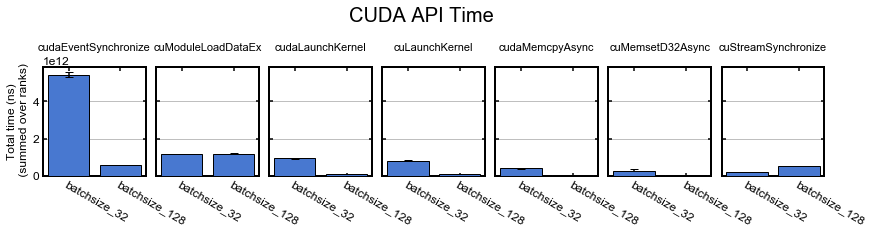

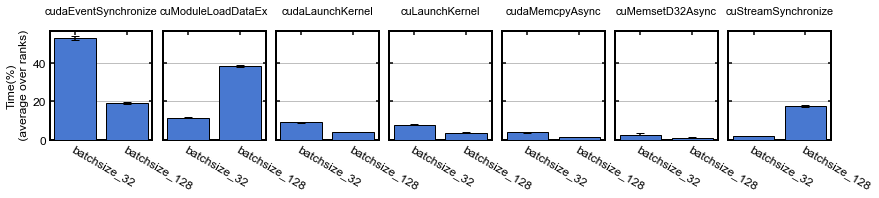

In [8]:
nRoutines = 7
all_batch = list(d._hash.keys())
ranksPerNodeSummit = 6
nRanks = np.array([ranksPerNodeSummit*8 for x in all_batch])
# Note 1_node and >1_node case has different routines, so can't compare exactly
expensiveRoutines = d['batchsize_32']['r0']['cudaapisum']['Name'][:nRoutines].values

# Compare raw times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
plt.suptitle('CUDA API Time', y=1.3, fontsize=20)
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[batch][r]['cudaapisum'].loc[d[batch][r]['cudaapisum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).sum() for batch in all_batch]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[batch][r]['cudaapisum'].loc[d[batch][r]['cudaapisum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).min() for batch in all_batch] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[batch][r]['cudaapisum'].loc[d[batch][r]['cudaapisum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[batch].keys()] ).max() for batch in all_batch]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - nRanks*np.array(expensiveRoutineTimesMin), 
                                         nRanks*np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='11')
    plt.gca().title.set_y(1.1)
    plt.bar(all_batch, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Total time (ns)\n (summed over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/Batch_CUDA_API_Time_ns.png', dpi=150, bbox_inches='tight')

# Compare % times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[batch][r]['cudaapisum'].loc[d[batch][r]['cudaapisum']['Name'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).mean() for batch in all_batch]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[batch][r]['cudaapisum'].loc[d[batch][r]['cudaapisum']['Name'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).min() for batch in all_batch] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[batch][r]['cudaapisum'].loc[d[batch][r]['cudaapisum']['Name'] == routine]['Time(%)'])
                                             for r in d[batch].keys()] ).max() for batch in all_batch]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - np.array(expensiveRoutineTimesMin), 
                                         np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='11')
    plt.gca().title.set_y(1.1)
    plt.bar(all_batch, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Time(%)\n (average over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/Batch_CUDA_API_Time_Percent.png', dpi=150, bbox_inches='tight')

## GPU Kernel Time vs. GPU Mem Time for Batch Size

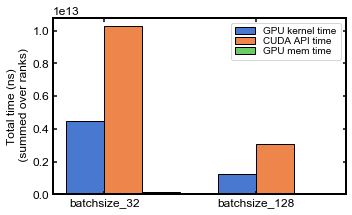

In [9]:
all_batch = list(d._hash.keys())
gpukerntime = [ sum([d[batch][r]['gpukernsum']['Total Time (ns)'].sum() 
                    for r in d[batch].keys()]) for batch in all_batch]
gpumemtime = [ sum([d[batch][r]['gpumemtimesum']['Total Time (ns)'].sum() 
                    for r in d[batch].keys()]) for batch in all_batch]
cudaapitime = [ sum([d[batch][r]['cudaapisum']['Total Time (ns)'].sum() 
                    for r in d[batch].keys()]) for batch in all_batch]
      
plt.ion()
plt.figure(figsize=figSize1x1)
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = gpukerntime
bars2 = cudaapitime
bars3 = gpumemtime
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=colors[0], width=barWidth, edgecolor='k', label='GPU kernel time')
plt.bar(r2, bars2, color=colors[1], width=barWidth, edgecolor='k', label='CUDA API time')
plt.bar(r3, bars3, color=colors[2], width=barWidth, edgecolor='k', label='GPU mem time')
     
plt.ylabel('Total time (ns)\n (summed over ranks)')
#plt.ylim(0, 3.2e12)
plt.xticks([r + 0.5*barWidth for r in range(len(bars1))], all_batch);

plt.legend(loc=1)
plt.tight_layout()
plt.savefig('figs/Batch_Time_vs_Batch.png', dpi=150, bbox_inches='tight')

In [10]:
gpukerneltime_cudacpitime_gpumemtime_sum = np.array(bars1)+np.array(bars2)+np.array(bars3)
print('Ratio of batch_128:batch_32 GPU kernel time + CUDA API time + GPU mem time = {}'.format(
    gpukerneltime_cudacpitime_gpumemtime_sum[1]/gpukerneltime_cudacpitime_gpumemtime_sum[0]))
print('Ratio of batch_128:batch_32 walltime = {}'.format(
    duration_seconds[1]/duration_seconds[0]))

Ratio of batch_128:batch_32 GPU kernel time + CUDA API time + GPU mem time = 0.29071377089035944
Ratio of batch_128:batch_32 walltime = 0.49442691171917313


Why is the speedup not more? Kernel and APU times summed are just $0.3$ times the batch size 32 case, but the speedup is only a factor of ~2, instead of factor ~3.3.  Is there 'hidden' time not accounted for here?

# Compare time-to-convergence (validation set accuracy) vs. batch size
Compare the walltime to get to get from 0.0 validation accuracy to 0.40 validation accuracy, varying the batch size (8 nodes).

In [31]:
# job    | batch size
# 871581 | 2

batch_size = np.array(['2'])

# Extract data from .out files
fileroot = '/ccs/home/mrowan/scratch/ml-performance-benchmark/deepcam/summit/'
files = [
            fileroot + '871581.out'  # 2
        ]

def get_time_and_global_accuracy(file):
    """
    Return the timestamp and validation set accuracy
    """
    x, y = [], []
    with open(file) as f:
        for line in f:
            match = re.search('\"time_ms\": ((\d+).*?) \"eval_accuracy\", \"value\": (0.\d+)', line)
            if match:
                #print(match.group())
                x.append(      match.group().split(' ')[ 1].replace(',',''))
                y.append(float(match.group().split(' ')[-1]))
    return np.array(x).astype(np.float), np.array(y).astype(np.float)
        
eval_accuracy = defaultdict(lambda: defaultdict(list))
for i,file in enumerate(files):
    print('working on batch_size {}'.format(batch_size[i]))
    x, y = get_time_and_global_accuracy(file)
    eval_accuracy[batch_size[i]]['time'] = x
    eval_accuracy[batch_size[i]]['eval_accuracy'] = y

working on batch_size 2


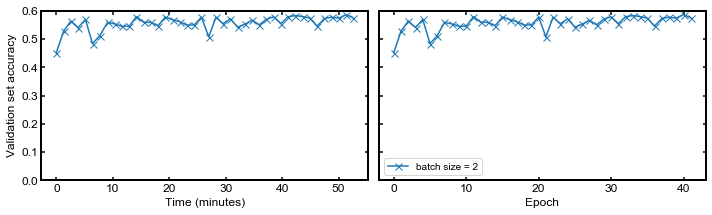

In [35]:
def time_in_seconds(start, stop):
    fmt = '%H:%M:%S.%f'
    t = datetime.datetime.strptime(stop, fmt) - datetime.datetime.strptime(start, fmt)
    return t.total_seconds()

# Plots for validation accuracy
fig_width = 10
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(fig_width, 0.5*fig_width/golden), 
                       sharey=True)

plt.sca(axs[0])
for i, bs in enumerate(batch_size):
    x, y = eval_accuracy[bs]['time'], eval_accuracy[bs]['eval_accuracy']
    x = [(item - x[0])/(60*1000.) for item in x] # ms --> minutes
    plt.plot(x, y, '-x',label='batch size = {}'.format(bs))


plt.xlabel('Time (minutes)')
plt.ylabel('Validation set accuracy')
#plt.hlines([0.4], x[0], x[-1], color='k', linestyle='--', alpha=0.75)

plt.sca(axs[1])
for i, bs in enumerate(batch_size):
    x, y = range(len(eval_accuracy[bs]['time'])), eval_accuracy[bs]['eval_accuracy']
    plt.plot(x, y, '-x',label='batch size = {}'.format(bs))
    
plt.xlabel('Epoch')
#plt.xticks(np.array(x, dtype=np.int), labels=np.array(x, dtype=np.int))
#plt.hlines([0.4], x[0], x[-1], color='k', linestyle='--', alpha=0.75,label='stop threshold')
plt.legend()

plt.ylim(0, 0.6)
plt.tight_layout()

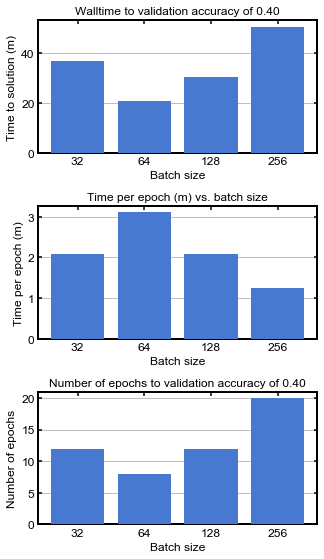

In [203]:
duration_minutes = []
epochs = []
time_per_epoch = []

for i,bs in enumerate(batch_size):
    x = eval_accuracy[bs]['time']
    x = [time_in_seconds(x[0], item)/60. for item in x] # minutes
    duration_minutes.append(x[-1])
    time_per_epoch.append(t_minutes/len(x))
    epochs.append(len(x))

fig_width = 5
fig, axs = plt.subplots(ncols=1, nrows=3, 
                        figsize=(fig_width, 3.*fig_width/golden))
                        #sharex=True)

# Time to conv. vs. batch size
x = [1, 2, 3, 4]

plt.sca(axs[0])
plt.bar(x, duration_minutes, zorder=5, color=colors[0])
plt.xlabel('Batch size')
plt.ylabel('Time to solution (m)')
plt.title('Walltime to validation accuracy of 0.40')
plt.gca().yaxis.grid(True)
plt.xticks(x, labels=batch_size);

# Time per epoch
plt.sca(axs[1])
plt.bar(x, time_per_epoch, zorder=5, color=colors[0])
plt.xlabel('Batch size')
plt.ylabel('Time per epoch (m)')
plt.title('Time per epoch (m) vs. batch size')
plt.gca().yaxis.grid(True)
plt.xticks(x, labels=batch_size);

# Epochs to convergence
plt.sca(axs[2])
plt.bar(x, np.array(epochs, dtype=np.int), zorder=5, color=colors[0])
plt.xlabel('Batch size')
plt.ylabel('Number of epochs')
plt.title('Number of epochs to validation accuracy of 0.40')
plt.gca().yaxis.grid(True)
plt.xticks(x, labels=batch_size);

fig.subplots_adjust(hspace=0.4)